In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
from numpy import array

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sodapy import Socrata


In [2]:
# # Uncomment the below to open data source, download sensor data, and store it as a csv locally.

# #Function to get Sensor count history data
# def sensor_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     sensor_data_id = "b2ak-trbp"
#     results = client.get(sensor_data_id, limit=5000000)
#     df = pd.DataFrame.from_records(results)
#     df = df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id', 'sensor_name', 'hourly_counts']]
#     return df

# sensor_history = sensor_count()

# sensor_history.to_csv('sensor_history.csv', index=False)

In [3]:
sensor_history = pd.read_csv('sensor_history.csv')

In [4]:
single_sensor = sensor_history[sensor_history.sensor_id == 4].copy()
single_sensor.sort_values('date_time', inplace=True, ascending=True)

In [5]:
#Make sensor counts range from 0 to 1.
maximum = single_sensor.hourly_counts.max()
single_sensor['hourly_counts'] = single_sensor['hourly_counts']/maximum

Now, it is important to understand that a model that attempts to make predictions on a time series can have reasonably good success by simply copying the value of the previous time step. In most cases, this value will be close to the next value in the sequence - and this can give the appearance of predictive ability where there is actually none.

So before building models and evaluating them, it is worthwhile setting up a baseline. This is the performance attained by simply copying the hourly count from the previous time step.

In [23]:
true_count = single_sensor.hourly_counts.to_numpy()
prev_count = true_count[1:true_count.shape[0]]
r2_baseline = r2_score(prev_count, true_count[0:true_count.shape[0]-1])   
print("The baseline R-squared score is:", r2_baseline)

The baseline R-squared score is: 0.8835439180056677


From this example we can see a fairly convincing score (at the time of writing this comment, it was around 0.884). However, we know that the model we just made is useless for our purposes.
We need to improve on this score!

In [5]:
sensor_seq = []
for i in range(0, len(single_sensor)):
    sensor_seq.append(single_sensor.hourly_counts.iloc[i])

In [13]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps = 392
# split into samples
X, y = split_sequence(sensor_seq, n_steps)


In [14]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [15]:
X_train = X[10001:80000]
X_val = X[80001:]
X_test = X[:10000]
Y_train = y[10001:80000]
Y_val = y[80001:]
Y_test = y[:10000]

In [20]:
epochs = 50
learning_rate = 0.00001
decay_rate = learning_rate / epochs
momentum = 0.8

# define model
model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')


In [21]:
# fit model
model.fit(X_train, Y_train, validation_data =(X_val, Y_val), epochs=45, verbose=1, batch_size = 64)


Epoch 1/45
1094/1094 [==============================] - 164s 145ms/step - loss: 0.0440 - val_loss: 0.0227
Epoch 2/45
1094/1094 [==============================] - 114s 104ms/step - loss: 0.0260 - val_loss: 0.0223
Epoch 3/45
1094/1094 [==============================] - 111s 101ms/step - loss: 0.0257 - val_loss: 0.0241
Epoch 4/45
1094/1094 [==============================] - 107s 98ms/step - loss: 0.0154 - val_loss: 0.0043
Epoch 5/45
1094/1094 [==============================] - 105s 96ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 6/45
1094/1094 [==============================] - 105s 96ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/45
1094/1094 [==============================] - 104s 95ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/45
1094/1094 [==============================] - 104s 95ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/45
1094/1094 [==============================] - 105s 96ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 10/45
1094/1094 [=============================

In [25]:
# demonstrate prediction
x_input = array(sensor_seq[10001:10393])
# x_input = x_input/maximum
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat * maximum)
print("actual next value: ", sensor_seq[10393] * maximum)

predicted next value:  [[127.42242]]
actual next value:  69.0


In [26]:
# demonstrate prediction
x_input = array(sensor_seq[10021:10413])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat * maximum)
print("actual next value: ", sensor_seq[10413] * maximum)

predicted next value:  [[1327.6808]]
actual next value:  1470.0


In [22]:
pred = model.predict(X_test)

313/313 [==============================] - 11s 30ms/step


In [23]:
r2_score(Y_test, pred)

0.9337978519191391

In [24]:
# model.save("model_3.h5")

In [3]:
# #Function to get Sensor count history data
# def micro_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     micro_data_id = "u4vh-84j8"
#     results = client.get(micro_data_id, limit=4000000)
#     if results:
#         df = pd.DataFrame.from_records(results)
#     return df

# micro_history = micro_count()

# micro_history.to_csv('micro_history.csv', index=False)

In [8]:
micro_history = pd.read_csv('micro_history.csv')

micro_history = micro_history[(micro_history.sensor_id == '5a') | (micro_history.sensor_id == '5b') |
                             (micro_history.sensor_id == '5c') | (micro_history.sensor_id == '0a') |
                             (micro_history.sensor_id == '0b') | (micro_history.sensor_id == '6')]

micro_history = micro_history[(micro_history.site_id == 1003) | (micro_history.site_id == 1009)]

micro_history = micro_history.drop(['id', 'gateway_hub_id', 'type', 'units'], axis=1)

micro_history.loc[micro_history.sensor_id == '5a', 'temp'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5b', 'humidity'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5c', 'pressure'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0a', 'part_2p5'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0b', 'part_10'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '6', 'wind'] = micro_history.value

micro_history.local_time = pd.to_datetime(micro_history.local_time, format='%Y-%m-%d')
micro_history['year'] = micro_history.local_time.dt.year
micro_history['month'] = micro_history.local_time.dt.month_name()
micro_history['mdate'] = micro_history.local_time.dt.day
micro_history['time'] = micro_history.local_time.dt.hour

micro_history = micro_history.drop(['site_id', 'sensor_id', 'value', 'local_time'], axis=1)
micro_history = micro_history.groupby(by=['year', 'month', 'mdate', 'time']).max()

ped_climate = sensor_history.merge(micro_history, on=('year', 'month', 'mdate', 'time'), how='inner')

In [74]:
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()

In [75]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [76]:
single_sensor_climate.head()

,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,2019-11-15T09:00:00.000,2019,November,15,Friday,9,4,Town Hall (West),1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,2019-11-15T10:00:00.000,2019,November,15,Friday,10,4,Town Hall (West),2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,2019-11-15T11:00:00.000,2019,November,15,Friday,11,4,Town Hall (West),2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,2019-11-15T12:00:00.000,2019,November,15,Friday,12,4,Town Hall (West),3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,2019-11-15T13:00:00.000,2019,November,15,Friday,13,4,Town Hall (West),4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [77]:
single_sensor_climate.drop(['date_time', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [78]:
single_sensor_climate.head()

,month,day,time,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,November,Friday,9,1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,November,Friday,10,2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,November,Friday,11,2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,November,Friday,12,3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,November,Friday,13,4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [79]:
month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

In [80]:
single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [83]:
scaler = MinMaxScaler()

In [84]:
scaled = scaler.fit_transform(single_sensor_climate)

In [117]:
new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

In [120]:
for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:9] = scaled[i][0:9]
    new_sequence[i][10] = scaled[i+1][3]

In [190]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

In [196]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

In [198]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

Epoch 1/50
167/167 - 1s - loss: 0.1047 - val_loss: 0.0792
Epoch 2/50
167/167 - 0s - loss: 0.0790 - val_loss: 0.0584
Epoch 3/50
167/167 - 0s - loss: 0.0508 - val_loss: 0.0444
Epoch 4/50
167/167 - 0s - loss: 0.0356 - val_loss: 0.0412
Epoch 5/50
167/167 - 0s - loss: 0.0324 - val_loss: 0.0397
Epoch 6/50
167/167 - 0s - loss: 0.0317 - val_loss: 0.0392
Epoch 7/50
167/167 - 0s - loss: 0.0311 - val_loss: 0.0387
Epoch 8/50
167/167 - 0s - loss: 0.0305 - val_loss: 0.0382
Epoch 9/50
167/167 - 0s - loss: 0.0299 - val_loss: 0.0379
Epoch 10/50
167/167 - 0s - loss: 0.0292 - val_loss: 0.0375
Epoch 11/50
167/167 - 0s - loss: 0.0282 - val_loss: 0.0366
Epoch 12/50
167/167 - 0s - loss: 0.0274 - val_loss: 0.0360
Epoch 13/50
167/167 - 0s - loss: 0.0269 - val_loss: 0.0353
Epoch 14/50
167/167 - 0s - loss: 0.0265 - val_loss: 0.0350
Epoch 15/50
167/167 - 0s - loss: 0.0260 - val_loss: 0.0349
Epoch 16/50
167/167 - 0s - loss: 0.0258 - val_loss: 0.0346
Epoch 17/50
167/167 - 0s - loss: 0.0257 - val_loss: 0.0342
Epoch 

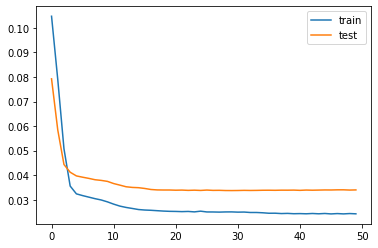

In [142]:
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# # fit network
# history = model.fit(train_x, train_y, epochs=50, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [145]:
epochs = 50
learning_rate = 0.00001
decay_rate = learning_rate / epochs
momentum = 0.8

# define model
model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [195]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=1000, verbose=1, batch_size = 32)

Epoch 1/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 2/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 3/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 4/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 5/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 6/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 7/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 8/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 9/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 10/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0029 - val_lo

Epoch 161/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 162/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 163/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 164/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 165/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 166/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 167/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 168/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 169/200
375/375 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 170/200
375/375 [==============================] - 2s 6ms/step - lo

In [199]:
yhat = model.predict(val_x)
val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

R-squared score: 0.938


In [200]:
# model.save("model_5.h5")